In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from community import community_louvain
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import math
from collections import Counter

In [2]:
!pip install python-louvain

In [3]:
file_path = 'data/wikiconflict.edges'

try:
    G = nx.read_edgelist(
        file_path,
        delimiter=',',
        # Correção crucial: Use 'Peso' (singular) em vez de 'Pesos'
        data=(('Peso', float), ('Timestamp', int)), 
        create_using=nx.DiGraph
    )

    print("Grafo carregado com sucesso!")
    print(f"Número de nós: {G.number_of_nodes()}")
    print(f"Número de arestas: {G.number_of_edges()}")

except FileNotFoundError:
    print(f"ERRO: Arquivo '{file_path}' não encontrado. Verifique se o arquivo está na pasta 'data'.")

Grafo carregado com sucesso!
Número de nós: 116836
Número de arestas: 2027871


In [5]:
u, v = random.choice(list(G.edges())) # Pega uma aresta aleatória

# 1. Obter os dados da aresta
dados_da_aresta = G.get_edge_data(u, v)

print("--- INSPEÇÃO DA ARESTA ---")
print(f"Aresta escolhida: ({u}, {v})")
print(f"Todos os dados/atributos da aresta: {dados_da_aresta}")

# 2. Tentar ler o valor do atributo 'Pesos'
valor_lido = dados_da_aresta.get('Peso')

print(f"Valor lido para 'Peso': {valor_lido}")
print(f"Tipo do valor lido: {type(valor_lido)}")

# 3. Tentar ler o valor como um float (para teste de conversão)
try:
    peso_convertido = float(valor_lido)
    print(f"Valor após conversão para float: {peso_convertido}")
except (TypeError, ValueError):
    print("ERRO: O valor não pôde ser convertido para número. A tipagem está incorreta.")

--- INSPEÇÃO DA ARESTA ---
Aresta escolhida: (6666, 7215)
Todos os dados/atributos da aresta: {'Peso': -2.1972245773362196, 'Timestamp': 1157646821}
Valor lido para 'Peso': -2.1972245773362196
Tipo do valor lido: <class 'float'>
Valor após conversão para float: -2.1972245773362196


In [4]:
# Criar os grafos vazios, mantendo a direção (DiGraph)
G_conc_novo = nx.DiGraph()
G_conf_novo = nx.DiGraph()

# Adicionar TODOS os 116k nós imediatamente (sempre importante)
G_conc_novo.add_nodes_from(G.nodes(data=True))
G_conf_novo.add_nodes_from(G.nodes(data=True))

# Itera APENAS uma vez no grafo G completo para filtrar e adicionar arestas
for u, v, data in G.edges(data=True):
    peso = data.get('Peso', 0)

    # Concordância
    if peso > 0:
        # Adiciona a aresta e TODOS os seus atributos (data)
        G_conc_novo.add_edge(u, v, **data)

    # Conflito
    elif peso < 0:
        G_conf_novo.add_edge(u, v, **data)

# --- FASE DE LIMPEZA ---
# Agora G_conc_novo e G_conf_novo estão com as arestas e atributos corretos.
# A única coisa que falta é remover os nós isolados.

isolados_conc = list(nx.isolates(G_conc_novo))
G_conc_limpo = G_conc_novo.copy()
G_conc_limpo.remove_nodes_from(isolados_conc)

isolados_conf = list(nx.isolates(G_conf_novo))
G_conf_limpo = G_conf_novo.copy()
G_conf_limpo.remove_nodes_from(isolados_conf)

# Tentar rodar as estatísticas novamente
print(f"Laços de CONCORDÂNCIA: {G_conc_limpo.number_of_edges()}")
print(f"Laços de CONFLITO: {G_conf_limpo.number_of_edges()}")

Laços de CONCORDÂNCIA: 774785
Laços de CONFLITO: 1251861


In [ ]:
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.15, iterations=20)

nx.draw_networkx_nodes(
    G,
    pos,
    node_size=500,
    node_color='skyblue'
)

nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle='->',
    arrowsize=15,
    edge_color='gray',
    alpha=0.6
)

nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

plt.title("Visualização do grafo")
plt.axis('off')
plt.show()


Arestas de Concordância na amostra: 0
Arestas de Conflito na amostra: 0


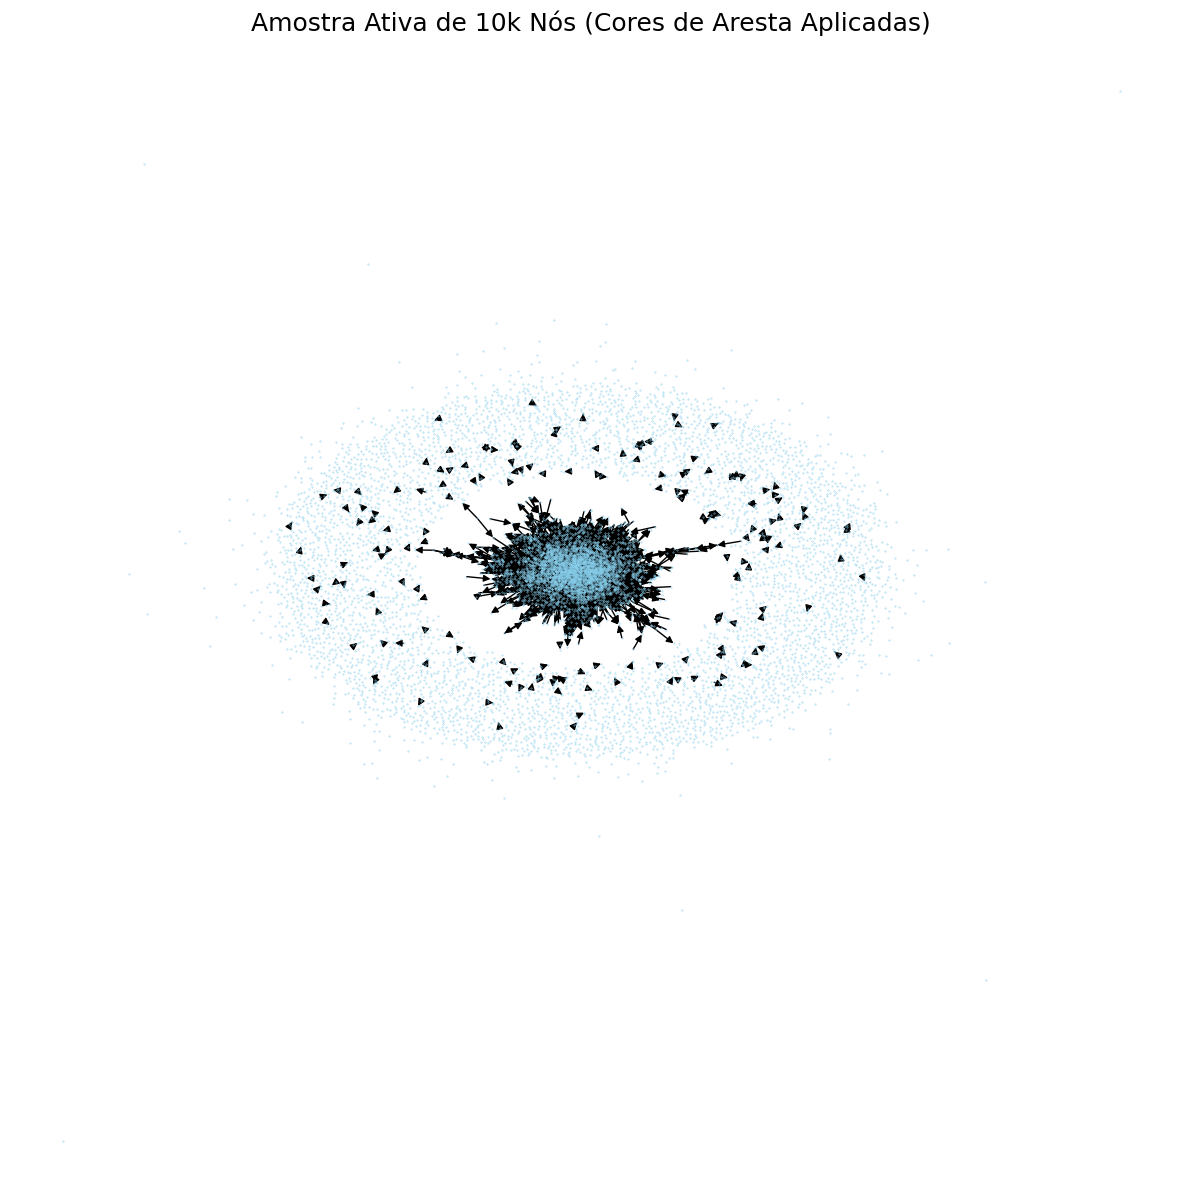

In [ ]:
# Seleciona uma amostra de 10000 nós aleatórios
amostra_nodos = random.sample(list(G.nodes()), 10000)

# 1. Gera o subgrafo induzido
G_amostra = G.subgraph(amostra_nodos)

plt.figure(figsize=(15, 15)) # Tamanho maior para 10k nós

# Calcula o layout com espaçamento (k maior)
pos = nx.spring_layout(G_amostra, k=0.8, iterations=100) # Aumentei iterações para estabilizar melhor

# --- CÓDIGO DE FILTRAGEM DE ARESTAS (AGORA ÚNICO E CORRETO) ---
arestas_conc = []
arestas_conf = []

for u, v, data in G_amostra.edges(data=True):
    peso = data.get('Pesos', 0) # Use 'Pesos'

    if peso > 0:
        arestas_conc.append((u, v))
    elif peso < 0:
        arestas_conf.append((u, v))

# Verifique as contagens para debug
print(f"Arestas de Concordância na amostra: {len(arestas_conc)}")
print(f"Arestas de Conflito na amostra: {len(arestas_conf)}")
# --- FIM DA FILTRAGEM ---

# 3. Desenho
# Desenha SOMENTE os nós
nx.draw(G_amostra, pos, with_labels=False, node_size=0.1, node_color='skyblue', ax=plt.gca())

# Desenha as arestas de concordância
nx.draw_networkx_edges(G_amostra, pos, edgelist=arestas_conc, edge_color='green', alpha=0.3, arrowstyle='->', arrowsize=3) # Aumentei alpha!

# Desenha as arestas de conflito
nx.draw_networkx_edges(G_amostra, pos, edgelist=arestas_conf, edge_color='red', alpha=0.3, style='dashed', arrowstyle='->', arrowsize=3) # Aumentei alpha!

plt.title("Amostra Ativa de 10k Nós (Cores de Aresta Aplicadas)", fontsize=18)
plt.axis('off')
plt.show()

In [5]:
# Contagem total de arestas (Concordância vs Conflito)
num_arestas_conc = G_conc_limpo.number_of_edges()
num_arestas_conf = G_conf_limpo.number_of_edges()

print("--- Estatísticas Básicas ---")
print(f"Total de Nós no Grafo G: {G.number_of_nodes()}")
print(f"Total de Arestas no Grafo G: {G.number_of_edges()}")
print("-" * 25)
print(f"Nós ATIVOS em Concordância: {G_conc_limpo.number_of_nodes()}")
print(f"Nós ATIVOS em Conflito: {G_conf_limpo.number_of_nodes()}")
print("-" * 25)
print(f"Total de Laços de CONCORDÂNCIA: {num_arestas_conc}")
print(f"Total de Laços de CONFLITO: {num_arestas_conf}")

# Exemplo de Análise: "A rede tem X% mais laços de Concordância do que de Conflito."

--- Estatísticas Básicas ---
Total de Nós no Grafo G: 116836
Total de Arestas no Grafo G: 2027871
-------------------------
Nós ATIVOS em Concordância: 48250
Nós ATIVOS em Conflito: 115822
-------------------------
Total de Laços de CONCORDÂNCIA: 774785
Total de Laços de CONFLITO: 1251861


In [6]:
componentes_conc = list(nx.weakly_connected_components(G_conc_limpo))
componentes_conc_maior = max(componentes_conc, key=len)

print("\n--- Estrutura da Concordância ---")
print(f"Número de 'Panelinhas' de Concordância: {len(componentes_conc)}")
print(f"Tamanho da Maior Componente (Coerência): {len(componentes_conc_maior)} nós")

componentes_conf = list(nx.weakly_connected_components(G_conf_limpo))
componentes_conf_maior = max(componentes_conf, key=len)

print("\n--- Estrutura do Conflito ---")
print(f"Número de 'Panelinhas' de Conflito: {len(componentes_conf)}")
print(f"Tamanho da Maior Componente (Coerência): {len(componentes_conf_maior)} nós")


--- Estrutura da Concordância ---
Número de 'Panelinhas' de Concordância: 358
Tamanho da Maior Componente (Coerência): 47366 nós

--- Estrutura do Conflito ---
Número de 'Panelinhas' de Conflito: 1799
Tamanho da Maior Componente (Coerência): 112070 nós


In [7]:
grau_conc = G_conc_limpo.degree()

grau_conc_dict = dict(grau_conc)
hubs_conc = sorted(grau_conc_dict.items(), key=lambda item: item[1], reverse=True)

print("\n--- Top 5 Nós (Hubs) da Concordância ---")
for node_id, grau in hubs_conc[:5]:
    print(f"ID do Usuário: {node_id}, Grau de Concordância: {grau}")

grau_conf = G_conf_limpo.degree()

grau_conf_dict = dict(grau_conf)
hubs_conf = sorted(grau_conf_dict.items(), key=lambda item: item[1], reverse=True)

print("\n--- Top 5 Nós (Hubs) de Treta ---")
for node_id, grau in hubs_conf[:5]:
    print(f"ID do Usuário: {node_id}, Grau de Conflito: {grau}")


--- Top 5 Nós (Hubs) da Concordância ---
ID do Usuário: 4215, Grau de Concordância: 18725
ID do Usuário: 491, Grau de Concordância: 13441
ID do Usuário: 5857, Grau de Concordância: 10369
ID do Usuário: 830, Grau de Concordância: 9692
ID do Usuário: 2742, Grau de Concordância: 8873

--- Top 5 Nós (Hubs) de Treta ---
ID do Usuário: 376, Grau de Conflito: 4818
ID do Usuário: 2727, Grau de Conflito: 2477
ID do Usuário: 164, Grau de Conflito: 2068
ID do Usuário: 3493, Grau de Conflito: 1980
ID do Usuário: 359, Grau de Conflito: 1769


In [10]:
G_conc_maior = G_conc_limpo.subgraph(componentes_conc_maior)

print(f"Nós na Componente Conexa Maior (CCM) de Concordância: {G_conc_maior.number_of_nodes()}")
print(f"Arestas na CCM de Concordância: {G_conc_maior.number_of_edges()}")
pos_ccm = nx.spring_layout(G_conc_maior, k=0.15, iterations=50)
plt.figure(figsize=(10, 10))
nx.draw(G_conc_maior, pos_ccm, with_labels=False,
        node_size=1, node_color='darkgreen', alpha=0.6, ax=plt.gca())
nx.draw_networkx_edges(G_conc_maior, pos_ccm, edge_color='green', alpha=0.1,
                       arrowstyle='->', arrowsize=3)

plt.title(f"Componente Conexa Maior da Rede de Concordância ({G_conc_maior.number_of_nodes()} Nós)", fontsize=14)
plt.axis('off')
plt.show()

Nós na Componente Conexa Maior (CCM) de Concordância: 47366
Arestas na CCM de Concordância: 774252


KeyboardInterrupt: 

In [10]:
# --- CÓDIGO ALTERNATIVO: CENTRALIDADE DE INTERMEDIAÇÃO (BETWEENNESS) ---
# Betweenness mostra se o nó atua como uma 'ponte' entre grupos.
# Nó Bot/Vândalo/Ponte: Espera-se um valor alto (alto controle de fluxo)

# Unir todos os hubs em uma única lista
todos_hubs = hubs_conc + hubs_conf

print("\n--- CALCULANDO CENTRALIDADE DE INTERMEDIAÇÃO (Betweenness) ---")
# Nota: Esta função pode ser lenta no grafo completo.
# Para acelerar, você pode rodar em uma amostra de nós.
# Vamos tentar rodar APENAS para os 10 hubs e ver o resultado.

# Usamos o grafo COMPLETO G, pois o betweenness de um nó depende de toda a rede.
betweenness = nx.betweenness_centrality(
    G,
    k=None, # Tenta calcular para todos, mas vamos inspecionar apenas os hubs
    normalized=True,
    weight='Peso' # Considera o peso das arestas (o que é vital para o seu grafo assinado)
)

print("\nHubs de CONCORDÂNCIA (Intermediação no Grafo Completo):")
for node_id in hubs_conc:
    # Recuperar o valor do dicionário 'betweenness'
    valor_b = betweenness.get(node_id, "Não Calculado")
    grau = G_conc_limpo.degree(node_id)
    print(f"ID {node_id} (Grau: {grau}): Betweenness = {valor_b:.4e}") # Formato científico para clareza

print("\nHubs de CONFLITO (Intermediação no Grafo Completo):")
for node_id in hubs_conf:
    valor_b = betweenness.get(node_id, "Não Calculado")
    grau = G_conf_limpo.degree(node_id)
    print(f"ID {node_id} (Grau: {grau}): Betweenness = {valor_b:.4e}")


--- CALCULANDO CENTRALIDADE DE INTERMEDIAÇÃO (Betweenness) ---

Hubs de CONCORDÂNCIA (Intermediação no Grafo Completo):


ValueError: Unknown format code 'e' for object of type 'str'

In [8]:
# --- CÓDIGO CORRIGIDO: ANÁLISE DE PAPÉIS (BOTS) ---

# 1. Redefinindo as listas como STRINGS (aspas) para coincidir com o grafo
hubs_conc_ids = ["4215", "491", "5857", "830", "2742"]
hubs_conf_ids = ["376", "2727", "164", "3493", "359"]

print("\n--- ANÁLISE DE PAPÉIS: REVISOR (SAÍDA) vs. AUTORIDADE (ENTRADA) ---")

# 1. Analisando os Hubs de CONCORDÂNCIA
print(">>> Hubs de CONCORDÂNCIA (Análise de Autoridade vs. Defensor):")
for node_id in hubs_conc_ids:
    # Tenta acessar. Se der erro, avisa qual o tipo do nó no grafo para debug
    try:
        in_d = G_conc_limpo.in_degree[node_id]  
        out_d = G_conc_limpo.out_degree[node_id]
        
        total = in_d + out_d
        
        if in_d > 0:
            razao = out_d / in_d
        else:
            razao = out_d 
        
        print(f"ID {node_id} (Total: {total})")
        print(f"   - Recebeu (In): {in_d} | Fez (Out): {out_d}")
        
        if out_d > in_d:
            perfil = "ATIVO (Defensor/Bot de Manutenção)"
        else:
            perfil = "PASSIVO (Autoridade/Conteúdo)"
            
        print(f"   - Perfil: {perfil}")
        print("-" * 30)
        
    except KeyError:
        print(f"ERRO: O nó '{node_id}' não foi encontrado no grafo G_conc_limpo.")
        print("Verifique se o ID está correto ou se o nó foi removido na limpeza.")

# 2. Analisando os Hubs de CONFLITO
print("\n>>> Hubs de CONFLITO (Análise de Vítima vs. Revisor Agressivo):")
for node_id in hubs_conf_ids:
    try:
        in_d = G_conf_limpo.in_degree[node_id]
        out_d = G_conf_limpo.out_degree[node_id]
        
        total = in_d + out_d
        
        print(f"ID {node_id} (Total: {total})")
        print(f"   - Foi Revertido (In): {in_d} | Reverteu Outros (Out): {out_d}")
        
        if out_d > (in_d * 2):
            perfil = "REVISOR AGRESSIVO (Provável Bot/Admin de Limpeza)"
        elif in_d > (out_d * 2):
            perfil = "ALVO DE DISPUTA (Conteúdo Controverso)"
        else:
            perfil = "GUERREIRO (Trocação Franca)"
            
        print(f"   - Perfil: {perfil}")
        print("-" * 30)
    except KeyError:
        print(f"ERRO: O nó '{node_id}' não foi encontrado no grafo G_conf_limpo.")


--- ANÁLISE DE PAPÉIS: REVISOR (SAÍDA) vs. AUTORIDADE (ENTRADA) ---
>>> Hubs de CONCORDÂNCIA (Análise de Autoridade vs. Defensor):
ID 4215 (Total: 18725)
   - Recebeu (In): 894 | Fez (Out): 17831
   - Perfil: ATIVO (Defensor/Bot de Manutenção)
------------------------------
ID 491 (Total: 13441)
   - Recebeu (In): 149 | Fez (Out): 13292
   - Perfil: ATIVO (Defensor/Bot de Manutenção)
------------------------------
ID 5857 (Total: 10369)
   - Recebeu (In): 892 | Fez (Out): 9477
   - Perfil: ATIVO (Defensor/Bot de Manutenção)
------------------------------
ID 830 (Total: 9692)
   - Recebeu (In): 151 | Fez (Out): 9541
   - Perfil: ATIVO (Defensor/Bot de Manutenção)
------------------------------
ID 2742 (Total: 8873)
   - Recebeu (In): 623 | Fez (Out): 8250
   - Perfil: ATIVO (Defensor/Bot de Manutenção)
------------------------------

>>> Hubs de CONFLITO (Análise de Vítima vs. Revisor Agressivo):
ID 376 (Total: 4818)
   - Foi Revertido (In): 23 | Reverteu Outros (Out): 4795
   - Perfil

In [13]:
edges_pos = [(u, v, d) for u, v, d in G.edges(data=True) if d.get('Peso', 0) > 0]

G_positive = nx.Graph()
G_positive.add_nodes_from(G.nodes())
G_positive.add_edges_from(edges_pos)

partition = community_louvain.best_partition(G_positive, weight='Peso') 

modularidade = community_louvain.modularity(partition, G_positive, weight='Peso')
num_comunidades = len(set(partition.values()))

print(f"Modularidade (Coesão dos Grupos): {modularidade:.4f}")
print(f"Número de Comunidades Identificadas: {num_comunidades}")

# 4. Salvar essa informação no Grafo para exportar pro Gephi depois
nx.set_node_attributes(G, partition, 'community')

Modularidade (Coesão dos Grupos): 0.4044
Número de Comunidades Identificadas: 68969


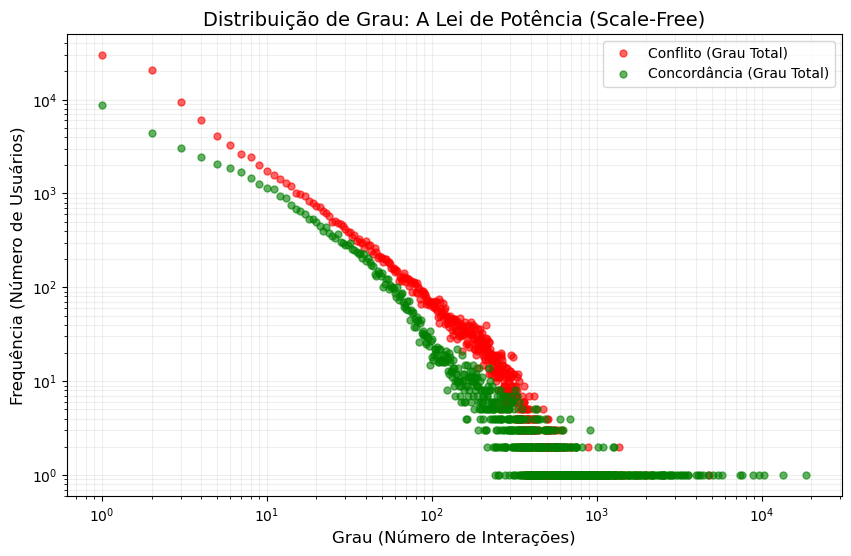

In [12]:
def plot_degree_distribution(G, label, color):
    # Pega os graus de todos os nós
    degrees = [d for n, d in G.degree()]
    
    # Calcula a frequência de cada grau
    values, counts = np.unique(degrees, return_counts=True)
    
    # Plota em escala Log-Log
    plt.loglog(values, counts, 'o', label=label, color=color, alpha=0.6, markersize=5)

plt.figure(figsize=(10, 6))

# Plotar Conflito (Vermelho)
plot_degree_distribution(G_conf_limpo, "Conflito (Grau Total)", "red")

# Plotar Concordância (Verde)
plot_degree_distribution(G_conc_limpo, "Concordância (Grau Total)", "green")

plt.title("Distribuição de Grau: A Lei de Potência (Scale-Free)", fontsize=14)
plt.ylabel("Frequência (Número de Usuários)", fontsize=12)
plt.xlabel("Grau (Número de Interações)", fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [8]:
# --- 1. CONFIGURAÇÃO DOS HUBS DE INTERESSE ---
# (Precisamos ter certeza de que estamos analisando os nós certos)
# Usamos strings se o grafo foi carregado sem nodetype=int
hubs_conc_ids = ["4215", "491", "5857", "830", "2742"]
hubs_conf_ids = ["376", "2727", "164", "3493", "359"]

# Unir para facilitar a busca no dicionário final
todos_hubs = hubs_conc_ids + hubs_conf_ids

# --- 2. CÁLCULO DA MÉTRICA ---
# k=1000: O segredo da velocidade. Aumente para 3000-5000 se tiver tempo e quiser mais precisão.
# weight='Peso': Importante para considerar a força das arestas (se houver variação).
# seed=42: Garante que, se você rodar de novo, o resultado (a escolha aleatória) será o mesmo.

betweenness_aprox = nx.betweenness_centrality(
    G, 
    k=5000, 
    normalized=True, 
    weight='Peso', 
    seed=42
)

print("Cálculo finalizado! Exibindo resultados para os Hubs:\n")

# --- 3. EXIBIÇÃO DOS RESULTADOS ---

print(">>> Hubs de CONCORDÂNCIA (Betweenness Estimado):")
for node_id in hubs_conc_ids:
    valor = betweenness_aprox.get(node_id, 0.0)
    # Mostra em notação científica (ex: 1.23e-04) para facilitar a leitura de números pequenos
    print(f"ID {node_id}: {valor:.5e}")

print("\n>>> Hubs de CONFLITO (Betweenness Estimado):")
for node_id in hubs_conf_ids:
    valor = betweenness_aprox.get(node_id, 0.0)
    print(f"ID {node_id}: {valor:.5e}")

Cálculo finalizado! Exibindo resultados para os Hubs:

>>> Hubs de CONCORDÂNCIA (Betweenness Estimado):
ID 4215: 1.08123e-03
ID 491: 6.91323e-06
ID 5857: 7.78789e-05
ID 830: 1.74099e-05
ID 2742: 2.34766e-04

>>> Hubs de CONFLITO (Betweenness Estimado):
ID 376: 1.55605e-06
ID 2727: 5.31481e-05
ID 164: 6.84732e-08
ID 3493: 2.20020e-04
ID 359: 2.94435e-07


In [9]:
# --- 1. CONFIGURAÇÃO DOS HUBS DE INTERESSE ---
# (Precisamos ter certeza de que estamos analisando os nós certos)
# Usamos strings se o grafo foi carregado sem nodetype=int
hubs_conc_ids = ["4215", "491", "5857", "830", "2742"]
hubs_conf_ids = ["376", "2727", "164", "3493", "359"]

# Unir para facilitar a busca no dicionário final
todos_hubs = hubs_conc_ids + hubs_conf_ids

# --- 2. CÁLCULO DA MÉTRICA ---
# k=1000: O segredo da velocidade. Aumente para 3000-5000 se tiver tempo e quiser mais precisão.
# weight='Peso': Importante para considerar a força das arestas (se houver variação).
# seed=42: Garante que, se você rodar de novo, o resultado (a escolha aleatória) será o mesmo.

betweenness_aprox = nx.betweenness_centrality(
    G, 
    k=10000, 
    normalized=True, 
    weight='Peso', 
    seed=42
)

print("Cálculo finalizado! Exibindo resultados para os Hubs:\n")

# --- 3. EXIBIÇÃO DOS RESULTADOS ---

print(">>> Hubs de CONCORDÂNCIA (Betweenness Estimado):")
for node_id in hubs_conc_ids:
    valor = betweenness_aprox.get(node_id, 0.0)
    # Mostra em notação científica (ex: 1.23e-04) para facilitar a leitura de números pequenos
    print(f"ID {node_id}: {valor:.5e}")

print("\n>>> Hubs de CONFLITO (Betweenness Estimado):")
for node_id in hubs_conf_ids:
    valor = betweenness_aprox.get(node_id, 0.0)
    print(f"ID {node_id}: {valor:.5e}")

Cálculo finalizado! Exibindo resultados para os Hubs:

>>> Hubs de CONCORDÂNCIA (Betweenness Estimado):
ID 4215: 8.53837e-04
ID 491: 1.40952e-04
ID 5857: 9.89462e-05
ID 830: 1.12489e-04
ID 2742: 1.60006e-04

>>> Hubs de CONFLITO (Betweenness Estimado):
ID 376: 4.63435e-06
ID 2727: 1.42347e-04
ID 164: 1.48929e-07
ID 3493: 1.71583e-04
ID 359: 5.88870e-07


In [12]:
primeiro_no = list(G.nodes())[0]
tipo_no = type(primeiro_no)

hubs_conc_raw = [4215, 491, 5857, 830, 2742]
hubs_conf_raw = [376, 2727, 164, 3493, 359]

if tipo_no == str:
    print("-> Convertendo lista de hubs para TEXTO (String) para coincidir.")
    hubs_conc = [str(x) for x in hubs_conc_raw]
    hubs_conf = [str(x) for x in hubs_conf_raw]
else:
    print("-> Mantendo lista de hubs como NÚMEROS (Int).")
    hubs_conc = hubs_conc_raw
    hubs_conf = hubs_conf_raw

betweenness_exact = nx.betweenness_centrality(
    G, 
    k=None, 
    normalized=True, 
    weight='Peso', 
    seed=42
)

nome_arquivo = 'betweenness_exact_FULL.pkl'
with open(nome_arquivo, 'wb') as f:
    pickle.dump(betweenness_exact, f)

print(f"Resultados salvos em '{nome_arquivo}'.")

print(">>> Hubs de CONCORDÂNCIA:")
for node_id in hubs_conc:
    valor = betweenness_exact.get(node_id, -1.0) 
    print(f"ID {node_id}: {valor:.5e}")

print("\n>>> Hubs de CONFLITO:")
for node_id in hubs_conf:
    valor = betweenness_exact.get(node_id, -1.0)
    print(f"ID {node_id}: {valor:.5e}")

-> Convertendo lista de hubs para TEXTO (String) para coincidir.
Resultados salvos em 'betweenness_exact_FULL.pkl'.
>>> Hubs de CONCORDÂNCIA:
ID 4215: 7.60490e-04
ID 491: 2.15472e-04
ID 5857: 1.38524e-04
ID 830: 8.52680e-05
ID 2742: 1.73490e-04

>>> Hubs de CONFLITO:
ID 376: 2.19005e-05
ID 2727: 2.57362e-04
ID 164: 2.83803e-07
ID 3493: 1.34845e-04
ID 359: 3.38466e-06


In [12]:
import networkx as nx

G_social = G_conc_limpo.to_undirected()

N = G_social.number_of_nodes()
E = G_social.number_of_edges()
k_medio = (2 * E) / N

C_real = nx.average_clustering(G_social) 
print(f"-> Coeficiente de Clusterização Real (C_real): {C_real:.5f}")

if N > 0:
    C_random = k_medio / N
else:
    C_random = 0

print(f"-> Clusterização Teórica em Rede Aleatória (C_rand): {C_random:.5e}")

# 5. Conclusão Final
if C_random > 0:
    ratio = C_real / C_random
    print(f"A Clusterização Real é {ratio:.2f} vezes maior que a esperada no acaso.")
    
    if ratio > 10:
        print("CONCLUSÃO: A rede é ALTAMENTE clusterizada (Mundo Pequeno confirmado).")
    else:
        print("CONCLUSÃO: A rede tem baixa clusterização.")

-> Coeficiente de Clusterização Real (C_real): 0.24215
-> Clusterização Teórica em Rede Aleatória (C_rand): 6.65605e-04
A Clusterização Real é 363.80 vezes maior que a esperada no acaso.
CONCLUSÃO: A rede é ALTAMENTE clusterizada (Mundo Pequeno confirmado).


In [ ]:
G_undirected = G_conc_limpo.to_undirected()
largest_cc_nodes = max(nx.connected_components(G_undirected), key=len)
LCC = G_undirected.subgraph(largest_cc_nodes).copy()

print(f"Componente Gigante Isolada com {LCC.number_of_nodes()} nós.")

num_samples = 47366
print(f"Calculando caminhos a partir de {num_samples} nós aleatórios...")

nodes_list = list(LCC.nodes())
sampled_sources = random.sample(nodes_list, num_samples)

path_lengths = []
diametro_estimado = 0

for source in sampled_sources:
    # Calcula a distância desse nó para TODOS os outros da LCC
    lengths = nx.single_source_shortest_path_length(LCC, source)
    
    # Guarda o maior caminho encontrado (candidato a diâmetro)
    max_len = max(lengths.values())
    if max_len > diametro_estimado:
        diametro_estimado = max_len
        
    # Guarda todas as distâncias para calcular a média
    path_lengths.extend(lengths.values())

avg_path = np.mean(path_lengths)
print(f"Distância Média Estimada: {avg_path:.4f}")
print(f"Diâmetro Estimado: {diametro_estimado}")

N_lcc = LCC.number_of_nodes()
log_n = math.log(N_lcc)

print(f"Distância esperada em rede aleatória (~ln N): {log_n:.2f}")

if avg_path < log_n * 2:
    print("CONCLUSÃO: O caminho é curto (Small World Confirmado).")
else:
    print("CONCLUSÃO: O caminho é longo.")

Componente Gigante Isolada com 47366 nós.
Calculando caminhos a partir de 47366 nós aleatórios...


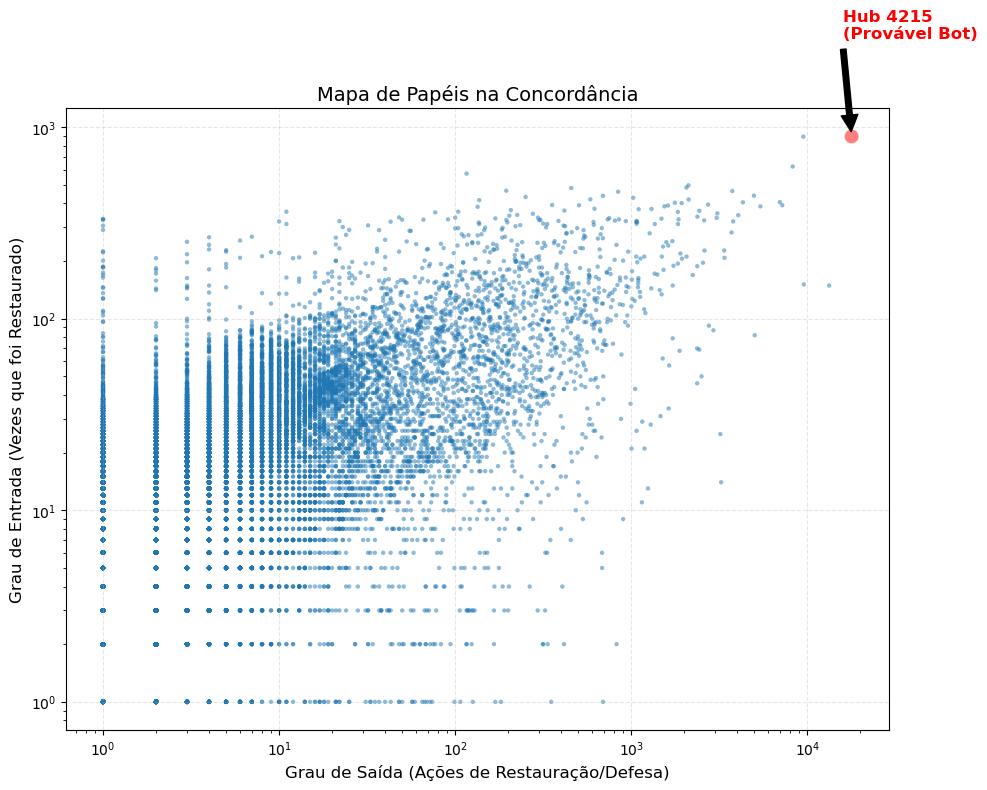

In [9]:
in_degrees = []
out_degrees = []
colors = []
sizes = []

# ID do Hub que queremos destacar (O "Suspeito")
hub_destaque = '4215' # (ou 4215 sem aspas, dependendo do seu grafo)

for node in G_conc_limpo.nodes():
    in_d = G_conc_limpo.in_degree(node)
    out_d = G_conc_limpo.out_degree(node)
    
    in_degrees.append(in_d)
    out_degrees.append(out_d)
    
    if str(node) == hub_destaque:
        colors.append('red') # Destaque
        sizes.append(100)    # Grande
    else:
        colors.append('#1f77b4') # Azul
        sizes.append(10)         # Pequeno
        
plt.figure(figsize=(10, 8))

plt.scatter(out_degrees, in_degrees, c=colors, s=sizes, alpha=0.5, edgecolors='none')

plt.title(f"Mapa de Papéis na Concordância", fontsize=14)
plt.xlabel("Grau de Saída (Ações de Restauração/Defesa)", fontsize=12)
plt.ylabel("Grau de Entrada (Vezes que foi Restaurado)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)

hub_in = G_conc_limpo.in_degree(hub_destaque)
hub_out = G_conc_limpo.out_degree(hub_destaque)

plt.annotate(f'Hub {hub_destaque}\n(Provável Bot)', 
             xy=(hub_out, hub_in), 
             xytext=(hub_out - 2000, hub_in + 2000), # Posição do texto
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, fontweight='bold', color='red')

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

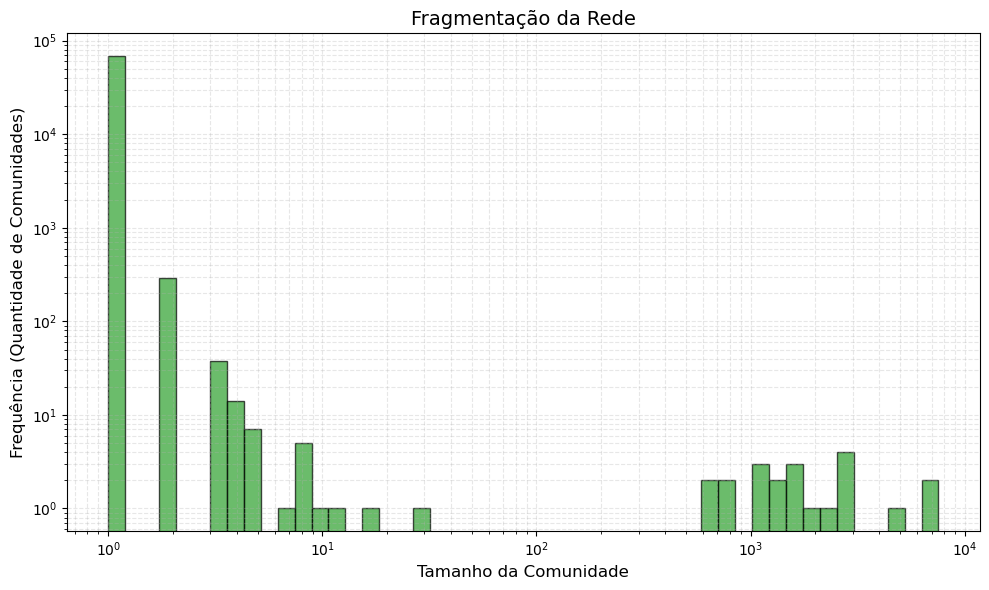

Total de Comunidades: 68969
Maior Comunidade: 7543 usuários
Comunidades com menos de 10 usuários: 68944


In [14]:
# partition = nx.get_node_attributes(G, 'community')

tamanhos = list(Counter(partition.values()).values())

plt.figure(figsize=(10, 6))

import numpy as np
bins = np.logspace(np.log10(min(tamanhos)), np.log10(max(tamanhos)), 50)

plt.hist(tamanhos, bins=bins, color='#2ca02c', alpha=0.7, edgecolor='black')

# 3. Configuração de Escala Log-Log (Essencial para ver a Cauda Longa)
plt.xscale('log')
plt.yscale('log')

plt.title("Fragmentação da Rede", fontsize=14)
plt.xlabel("Tamanho da Comunidade", fontsize=12)
plt.ylabel("Frequência (Quantidade de Comunidades)", fontsize=12)

plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total de Comunidades: {len(tamanhos)}")
print(f"Maior Comunidade: {max(tamanhos)} usuários")
print(f"Comunidades com menos de 10 usuários: {sum(1 for t in tamanhos if t < 10)}")